In [298]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Open the NetCDF file
# ds = Dataset("/data92/PeterChang/ESM_2025/f09.F2000_0101_0601_daily.nc", mode='r')
ds = Dataset("/data92/PeterChang/ESM_2025/f09.F2000_MJO_1year.cam.h0.1year.nc", mode='r')
# ds = Dataset("/data92/PeterChang/ESM_2025/f09.F2000_MJO_1.5anomaly.cam.h0.1101_0201.nc", mode='r')

# View metadata
# print(ds)

# List variables
print(ds.variables.keys())

# Access a variable
q    = ds.variables['Q'][:]  # replace with actual variable name
U200 = ds.variables['U200'][:]
U850 = ds.variables['U850'][:]
lat  = ds.variables['lat'][:]
lon  = ds.variables['lon'][:]
lev  = ds.variables['lev'][:]
time  = ds.variables['time'][:]

print(lev.shape)


dict_keys(['time', 'time_bnds', 'slat', 'lat', 'lon', 'lev', 'lev_bnds', 'ilev', 'ilev_bnds', 'date', 'datesec', 'w_stag', 'nlon', 'wnummax', 'gw', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'AEROD_v', 'ANRAIN', 'ANSNOW', 'AODDUST1', 'AODDUST3', 'AODVIS', 'AQRAIN', 'AQSNOW', 'AREI', 'AREL', 'AWNC', 'AWNI', 'BURDEN1', 'BURDEN2', 'BURDEN3', 'BURDENBC', 'BURDENDUST', 'BURDENPOM', 'BURDENSEASALT', 'BURDENSO4', 'BURDENSOA', 'CCN3', 'CDNUMC', 'CGH', 'CGS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'DCQ', 'DMS_SRF', 'DTCOND', 'DTV', 'EMISCLD', 'FICE', 'FLDS', 'FLNS', 'FLNSC', 'FLNT', 'FLNTC', 'FLUT', 'FLUTC', 'FREQI', 'FREQL', 'FREQR', 'FREQS', 'FSDS', 'FSDSC', 'FSNS', 'FSNSC', 'FSNT', 'FSNTC', 'FSNTOA', 'FSNTOAC', 'FSUTOA', 'H2O2_SRF', 'H2SO4_SRF', 'ICEFRAC', 'ICIMR', 'ICWMR', 'IWC', 'KBFS', 'KHFS', 'KQFS', 'KSCT', 'KSCU', 'KVF', 'KVH', 'KVM', 'LANDFRAC', 'LHFLX', 'LWCF', 'NUMICE', 'NUMLIQ', 'OCNFRAC', 'OMEGA', 'OMEGAT'

In [299]:
time

masked_array(data=[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
                     9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
                    18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
                    27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
                    36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
                    45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
                    54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
                    63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
                    72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,
                    81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
                    90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
                    99., 100., 101., 102., 103., 104., 105., 106., 107.,
                   108., 109., 110., 111., 112., 113., 114., 115., 116.,
                   117., 118., 119., 120., 121., 12

## Variable Preprocessing

In [300]:
# Calculate the vertically integrate Q
# Compute pressure layer thickness (Δp) using diff
delta_p = np.diff(lev)  # shape: (29,)

# Pad to match q's 2nd dimension (30 levels)
# You can either repeat the last diff or assume same thickness
delta_p = np.append(delta_p, delta_p[-1])  # shape: (30,)

# Reshape delta_p to broadcast: (1, 30, 1, 1)
delta_p_reshaped = delta_p.reshape(1, 30, 1, 1)

# Multiply and sum over pressure axis
q_integrated = np.sum(q * delta_p_reshaped, axis=1)*100/9.8  # shape: (150, 188, 288)


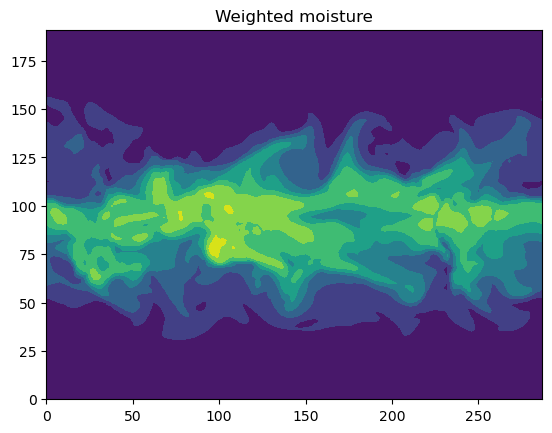

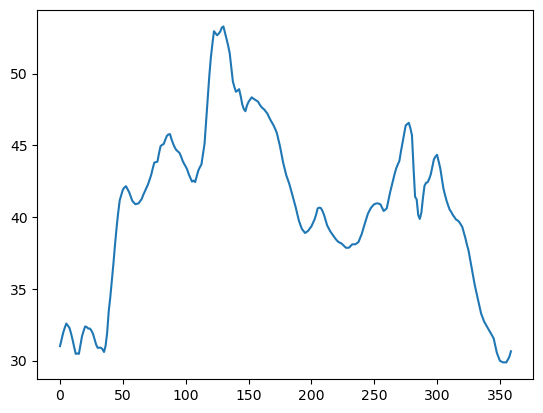

In [301]:
# Reshape to (1, 1, 188, 1)
weights_reshaped = np.cos(lat/180*np.pi).reshape(1, -1, 1)

# Apply weights
q_weighted = q_integrated * weights_reshaped
U850_weighted = U850 * weights_reshaped
U200_weighted = U200 * weights_reshaped

# average over tropics 
tropics_mask    = (lat >= -15) & (lat <= 15)
q_tropics       = q_weighted[:, tropics_mask, :].mean(axis=1)
U850_tropics    = U850_weighted[:, tropics_mask, :].mean(axis=1)  
U200_tropics    = U200_weighted[:, tropics_mask, :].mean(axis=1)  



plt.figure()
plt.contourf(q_weighted[0,])
plt.title('Weighted moisture')

plt.figure()
plt.plot(lon,q_tropics[0,:].T)

In [302]:
# Remove Seasonal Cycle
from scipy.signal import butter, filtfilt

# Define high-pass filter
def highpass_filter(data, cutoff_period, dt, order=4):
    nyquist = 0.5 / dt
    cutoff_freq = 1 / cutoff_period
    normal_cutoff = cutoff_freq / nyquist

    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data, axis=0)

# Example usage:
dt = 1  # daily data
cutoff_period       = 40 #40 #58  # filter out components with period > 30 days
q_highpass_60day    = highpass_filter(q_tropics, cutoff_period, dt)
U850_highpass_60day = highpass_filter(U850_tropics, cutoff_period, dt)
U200_highpass_60day = highpass_filter(U200_tropics, cutoff_period, dt)
cutoff_period       = 14 #14
q_highpass_14day    = highpass_filter(q_tropics, cutoff_period, dt)
U850_highpass_14day = highpass_filter(U850_tropics, cutoff_period, dt)
U200_highpass_14day = highpass_filter(U200_tropics, cutoff_period, dt)
q_intra             = q_highpass_60day - q_highpass_14day
U850_intra          = U850_highpass_60day- U850_highpass_14day
U200_intra          = U200_highpass_60day- U200_highpass_14day



In [303]:
def standardize_over_time(X):
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    return (X - mean) / std

q_std = standardize_over_time(q_intra)
u850_std = standardize_over_time(U850_intra)
u200_std = standardize_over_time(U200_intra)


# Stack all standardized variables along the spatial (longitude) axis
X = np.concatenate([q_std, u850_std, u200_std], axis=1)  # shape: (time, 3 * lon)


from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pcs = pca.fit_transform(X)        # shape: (time, n_modes)
eofs = pca.components_            # shape: (n_modes, 3 * lon)
explained_variance = pca.explained_variance_ratio_


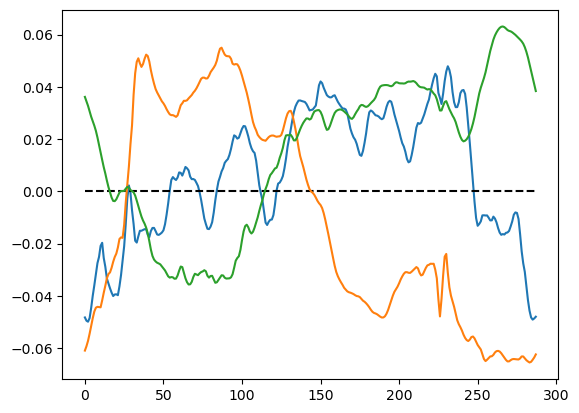

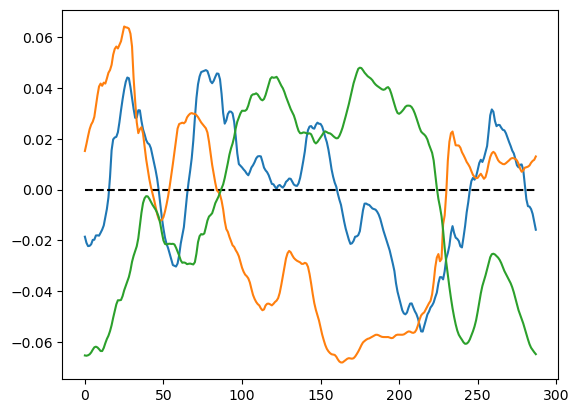

In [304]:
plt.figure()
lon_size = np.size(lon)
plt.plot(eofs[0,:lon_size])
plt.plot(eofs[0,:lon_size]*0,'k--')
plt.plot(eofs[0,lon_size:2*lon_size])
plt.plot(eofs[0,2*lon_size:3*lon_size])

plt.figure()
lon_size = np.size(lon)
plt.plot(eofs[1,:lon_size])
plt.plot(eofs[0,:lon_size]*0,'k--')
plt.plot(eofs[1,lon_size:2*lon_size])
plt.plot(eofs[1,2*lon_size:3*lon_size])


In [305]:
def plot_mjo_phase_space(figsize):
    
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.lines as lines
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.set_xticks(range(-4,5))
    ax.set_yticks(range(-4,5))

    # plot mjo phase diagram lines
    line1 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line1)
        
    line2 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(np.pi/4), 4], color='black', linestyle='--', lw=1)
    ax.add_line(line2)
        
    line3 = lines.Line2D([np.cos(np.pi/4), 4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line3)
        
    line4 = lines.Line2D([np.cos(3*np.pi/4), -4], [np.sin(7*np.pi/4), -4], color='black', linestyle='--', lw=1)
    ax.add_line(line4)
        
    line5 = lines.Line2D([-4, -1], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line5)
        
    line6 = lines.Line2D([1, 4], [0, 0], color='black', linestyle='--', lw=1)
    ax.add_line(line6)
        
    line7 = lines.Line2D([0, 0], [1, 4], color='black', linestyle='--', lw=1)
    ax.add_line(line7)
        
    line8 = lines.Line2D([0, 0], [-1, -4], color='black', linestyle='--', lw=1)
    ax.add_line(line8)
        
    amp1_circ = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_patch(amp1_circ)
        
    # add phase diagram texts
    ax.text( 1,3,'Phase 6', size='x-large', weight='semibold')
    ax.text(-2,3,'Phase 7', size='x-large', weight='semibold')
    ax.text(2.8,1  ,'Phase 5', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,1  ,'Phase 8', size='x-large', weight='semibold', ha='center')
        
    ax.text( 1,-3,'Phase 3', size='x-large', weight='semibold')
    ax.text(-2,-3,'Phase 2', size='x-large', weight='semibold')
    ax.text(2.8,-1  ,'Phase 4', size='x-large', weight='semibold', ha='center')
    ax.text(-2.8,-1  ,'Phase 1', size='x-large', weight='semibold', ha='center')
        
    ax.text( 0,3.7,'Pacific Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text( 0,-3.8,'Indian Ocean', ha='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(-3.8,0,'West. Hem., Africa', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
    ax.text(3.7,0,'Maritime Continent', va='center', rotation='vertical', bbox=dict(facecolor='white', edgecolor='white'))
        
    ax.set_xlabel('RMM1')
    ax.set_ylabel('RMM2')

    return fig, ax

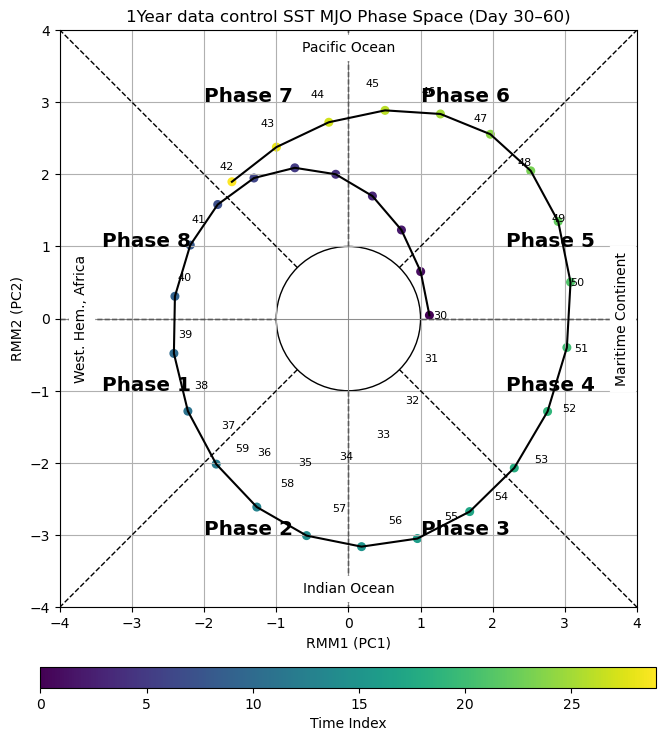

In [309]:
# Assume pcs[:, 0] = PC1, pcs[:, 1] = PC2
PC1 = pcs[:, 0]
PC2 = pcs[:, 1]

# Choose time range
t_start, t_end = 30, 60
PC1_sel = PC1[t_start:t_end]/np.std(PC1)
PC2_sel = PC2[t_start:t_end]/np.std(PC2)

# Compute amplitude
amplitude = np.sqrt(PC1_sel**2 + PC2_sel**2)

# Create figure
# plt.figure(figsize=(6,6))
fig, ax = plot_mjo_phase_space(figsize=(8,8))

plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)

# Plot phase space trajectory
plt.plot(PC1_sel, -PC2_sel, 'k-', lw=1.5)
CS = plt.scatter(PC1_sel, -PC2_sel, c=np.arange(len(PC1_sel)), cmap='viridis', s=30)

# Add day numbers (optional)
for i in range(len(PC1_sel)):
    plt.text(PC1_sel[i]+0.05, PC2_sel[i]+0.05, str(t_start+i), fontsize=8)

# Labels and styling
plt.xlabel('RMM1 (PC1)')
plt.ylabel('RMM2 (PC2)')
plt.title('1Year data control SST MJO Phase Space (Day {}–{})'.format(t_start, t_end))
plt.gca().set_aspect('equal')
plt.grid(True)
plt.colorbar(CS, label='Time Index', orientation="horizontal", shrink=0.8, aspect=30, pad=0.08)
plt.tight_layout()
plt.show()


In [277]:
explained_variance

array([0.15360942, 0.12790677, 0.08836768, 0.07147185, 0.06124977])

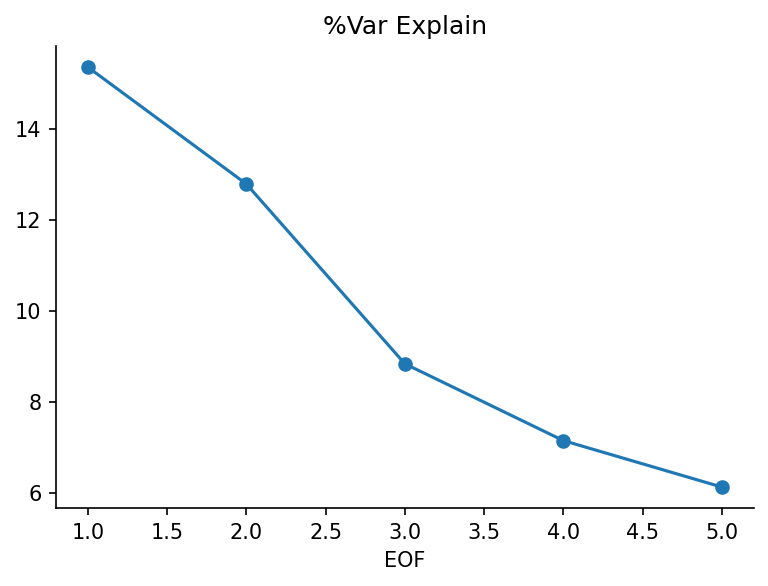

In [278]:
fig, ax = plt.subplots(1, figsize=(6,4), dpi=150)
ax.plot(np.arange(1,6,1), explained_variance * 100, '-o')
ax.set_title("%Var Explain")
ax.set_xlabel("EOF")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.set_xticks(np.arange(1, 11, 1))  
plt.show()
